# Student ID: p233340 Name: Kwok Tsz Yi #

**What is Sentiment Analysis?**

Sentiment analysis (also known as opinion mining) is one of the many applications of Natural Language Processing. It is a set of methods and techniques used for extracting subjective information from text or speech, such as opinions or attitudes. In simple terms, it involves classifying a piece of text as positive, negative or neutral.

![Imgur](https://i.imgur.com/n2MmZrY.png)
<!-- <img src="subdirect****ory/MyImage.png",width=60,height=60> -->

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label ‘1’ denotes the tweet is racist/sexist and label ‘0’ denotes the tweet is not racist/sexist, your objective is to predict the labels on the given test dataset.


#### Table of contents

1. Understand the Text Data
1. Tweets Preprocessing and Cleaning
    1. Data Inspection
    1. Data Cleaning
1. Story Generation and Visualization from Tweets
1. Extracting Features from Cleaned Tweets
    1. Bag-of-Words
    1. TF-IDF
    1. Word Embeddings
1. Model Building: Sentiment Analysis
    1. Logistic Regression
    1. Support Vector Machine
    1. RandomForest
    1. XGBoost

In [5]:
# Let’s load the libraries

import re    # for regular expressions
import nltk  # for text manipulation
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 200)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
# Let’s read train and test datasets.
train  = pd.read_csv('train_E6oV3lV.csv')
test = pd.read_csv('test_tweets_anuFYb8.csv')

Text is a highly unstructured form of data, various types of noise are present in it and the data is not readily analyzable without any pre-processing. The entire process of cleaning and standardization of text, making it noise-free and ready for analysis is known as text preprocessing. We will divide it into 2 parts:

* Data Inspection
* Data Cleaning

#### Data Inspection
Let’s check out a few **non** racist/sexist tweets.

In [7]:
train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


Now check out a few racist/sexist tweets.

In [8]:
train[train['label'] == 1].head(10)


,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk folx running around loving themselves and promoting our greatness
77,78,1,"@user hey, white people: you can call people 'white' by @user #race #identity #medâ¦"
82,83,1,how the #altright uses &amp; insecurity to lure men into #whitesupremacy
111,112,1,@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics bringsâ¦


There are quite a many words and characters which are not really required. So, we will try to keep only those words which are important and add value.

Let’s check dimensions of the train and test dataset.

In [9]:
train.shape, test.shape

((31962, 3), (17197, 2))

Train set has 31,962 tweets and test set has 17,197 tweets.

Let’s have a glimpse at label-distribution in the train dataset.

In [10]:
train["label"].value_counts()


label
0    29720
1     2242
Name: count, dtype: int64

In the train dataset, we have 2,242 (~7%) tweets labeled as racist or sexist, and 29,720 (~93%) tweets labeled as non racist/sexist. So, it is an imbalanced classification challenge.

Now we will check the distribution of length of the tweets, in terms of words, in both train and test data.

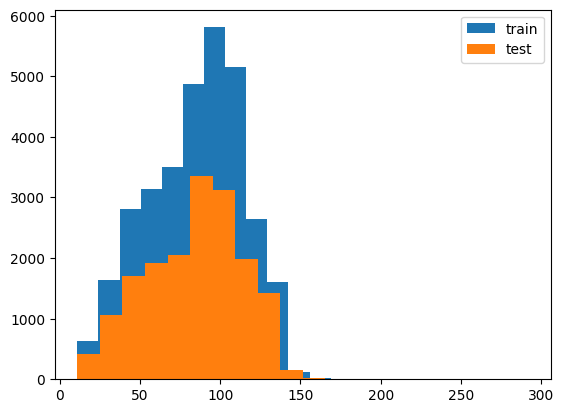

In [11]:
plt.hist(train.tweet.str.len(), bins=20, label='train')
plt.hist(test.tweet.str.len(), bins=20, label='test')
plt.legend()
plt.show()

In any natural language processing task, cleaning raw text data is an important step. It helps in getting rid of the unwanted words and characters which helps in obtaining better features. If we skip this step then there is a higher chance that you are working with noisy and inconsistent data. The objective of this step is to clean noise those are less relevant to find the sentiment of tweets such as punctuation, special characters, numbers, and terms which don’t carry much weightage in context to the text.

Before we begin cleaning, let’s first combine train and test datasets. Combining the datasets will make it convenient for us to preprocess the data. Later we will split it back into train and test data.

In [12]:
combi = train._append(test, ignore_index=True, sort=True)
combi.shape

(49159, 3)

Given below is a user-defined function to remove unwanted text patterns from the tweets.

In [13]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

We will be following the steps below to clean the raw tweets in out data.

1. We will remove the twitter handles as they are already masked as @user due to privacy concerns. These twitter handles hardly give any information about the nature of the tweet.

1. We will also get rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different types of tweets.

1. Most of the smaller words do not add much value. For example, ‘pdx’, ‘his’, ‘all’. So, we will try to remove them as well from our data.

1. Lastly, we will normalize the text data. For example, reducing terms like loves, loving, and lovable to their base word, i.e., ‘love’.are often used in the same context. If we can reduce them to their root word, which is ‘love’. It will help in reducing the total number of unique words in our data without losing a significant amount of information.

**1. Removing Twitter Handles (@user)**

Let’s create a new column tidy_tweet, it will contain the cleaned and processed tweets. Note that we have passed “@[]*” as the pattern to the remove_pattern function. It is actually a regular expression which will pick any word starting with ‘@’.

In [14]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")
combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow dannyâ¦
7,8,0.0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0.0,@user @user welcome here ! i'm it's so #gr8 !,welcome here ! i'm it's so #gr8 !


**2. Removing Punctuations, Numbers, and Special Characters**

Here we will replace everything except characters and hashtags with spaces. The regular expression “[^a-zA-Z#]” means anything except alphabets and ‘#’.

In [15]:
combi.tidy_tweet = combi.tidy_tweet.str.replace("[^a-zA-Z#]", " ")
combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow dannyâ¦
7,8,0.0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0.0,@user @user welcome here ! i'm it's so #gr8 !,welcome here ! i'm it's so #gr8 !


**3. Removing Short Words**

We have to be a little careful here in selecting the length of the words which we want to remove. So, I have decided to remove all the words having length 3 or less. For example, terms like “hmm”, “oh” are of very little use. It is better to get rid of them.

In [16]:
combi.tidy_tweet = combi.tidy_tweet.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit can't cause they don't offer wheelchair vans pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society #motivation
5,6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,[2/2] huge fare talking before they leave. chaos disputes when they there. #allshowandnogo
6,7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow dannyâ¦
7,8,0.0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,next school year year exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,won!!! love land!!! #allin #cavs #champions #cleveland #clevelandcavaliers
9,10,0.0,@user @user welcome here ! i'm it's so #gr8 !,welcome here it's #gr8


You can see the difference between the raw tweets and the cleaned tweets (tidy_tweet) quite clearly. Only the important words in the tweets have been retained and the noise (numbers, punctuations, and special characters) has been removed.

**4. Text Normalization**

Here we will use nltk’s PorterStemmer() function to normalize the tweets. But before that we will have to tokenize the tweets. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [17]:
tokenized_tweet = combi.tidy_tweet.apply(lambda x: x.split())
tokenized_tweet.head()

0                                   [when, father, dysfunctional, selfish, drags, kids, into, dysfunction., #run]
1    [thanks, #lyft, credit, can't, cause, they, don't, offer, wheelchair, vans, pdx., #disapointed, #getthanked]
2                                                                                         [bihday, your, majesty]
3                                      [#model, love, take, with, time, urð±!!!, ðððð, ð¦ð¦ð¦]
4                                                                             [factsguide:, society, #motivation]
Name: tidy_tweet, dtype: object

In [18]:
# Now we can normalize the tokenized tweets.

from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0                                   [when, father, dysfunct, selfish, drag, kid, into, dysfunction., #run]
1    [thank, #lyft, credit, can't, caus, they, don't, offer, wheelchair, van, pdx., #disapoint, #getthank]
2                                                                                  [bihday, your, majesti]
3                               [#model, love, take, with, time, urð±!!!, ðððð, ð¦ð¦ð¦]
4                                                                           [factsguide:, societi, #motiv]
Name: tidy_tweet, dtype: object

In [19]:
# Now let’s stitch these tokens back together. It can easily be done using nltk’s MosesDetokenizer function.

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
combi['tidy_tweet'] = tokenized_tweet
combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunct selfish drag kid into dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thank #lyft credit can't caus they don't offer wheelchair van pdx. #disapoint #getthank
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: societi #motiv
5,6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,[2/2] huge fare talk befor they leave. chao disput when they there. #allshowandnogo
6,7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camp tomorrow dannyâ¦
7,8,0.0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,next school year year exams.ð¯ can't think about that ð­ #school #exam #hate #imagin #actorslif #revolutionschool #girl
8,9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,won!!! love land!!! #allin #cav #champion #cleveland #clevelandcavali
9,10,0.0,@user @user welcome here ! i'm it's so #gr8 !,welcom here it' #gr8


In this section, we will explore the cleaned tweets. Exploring and visualizing data, no matter whether its text or any other data, is an essential step in gaining insights. Do not limit yourself to only these methods told in this course, feel free to explore the data as much as possible.

Before we begin exploration, we must think and ask questions related to the data in hand. A few probable questions are as follows:

* What are the most common words in the entire dataset?
* What are the most common words in the dataset for negative and positive tweets, respectively?
* How many hashtags are there in a tweet?
* Which trends are associated with my dataset?
* Which trends are associated with either of the sentiments? Are they compatible with the sentiments?

**A) Understanding the common words used in the tweets: WordCloud**

Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot.

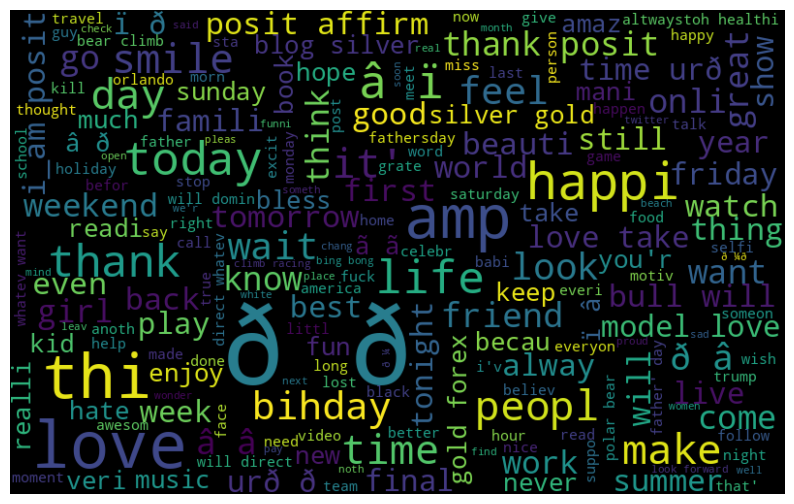

In [20]:
all_words = ' '.join([text for text in combi['tidy_tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. Words like love, great, friend, life are the most frequent ones. It doesn’t give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes (racist/sexist or not) in our train data.

**B) Words in non racist/sexist tweets**

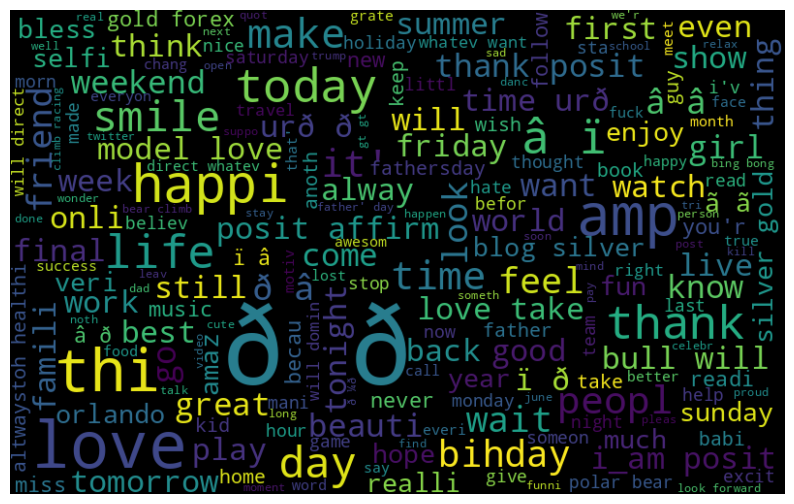

In [21]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Most of the frequent words are compatible with the sentiment, i.e, non-racist/sexists tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative, racist, and sexist terms.

**C) Racist/Sexist Tweets**

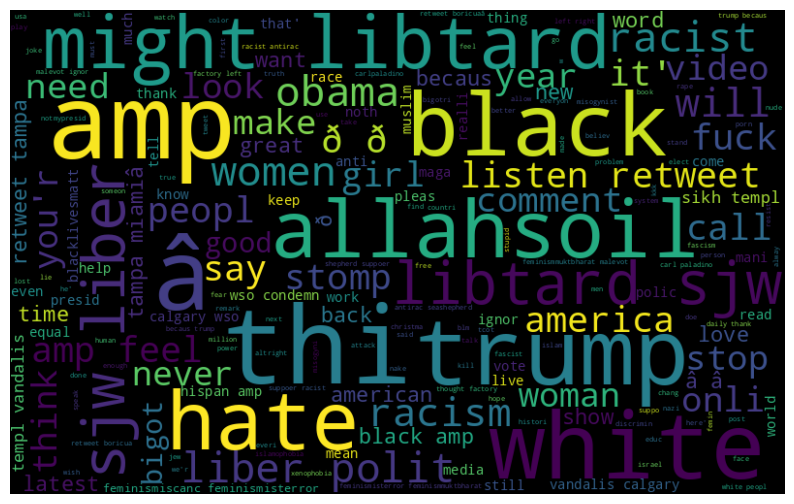

In [22]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will the hashtags/trends in our twitter data.

**D) Understanding the impact of Hashtags on tweets sentiment**

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.

For instance, given below is a tweet from our dataset:

![imgur](https://i.imgur.com/phLSlwB.png)

The tweet seems sexist in nature and the hashtags in the tweet convey the same feeling.

We will store all the trend terms in two separate lists — one for non-racist/sexist tweets and the other for racist/sexist tweets.


In [23]:
# function to collect hashtags

def hashtag_extract(x):
    hashtags = []    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [24]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

In [25]:
# extracting hashtags from racist/sexist tweets

HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

In [26]:
# unnesting list

HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top ‘n’ hashtags. So, first let’s check the hashtags in the non-racist/sexist tweets.

**Non-Racist/Sexist Tweets**

In [27]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame(
    {
    'Hashtag': list(a.keys()),
    'Count': list(a.values())
    }
)

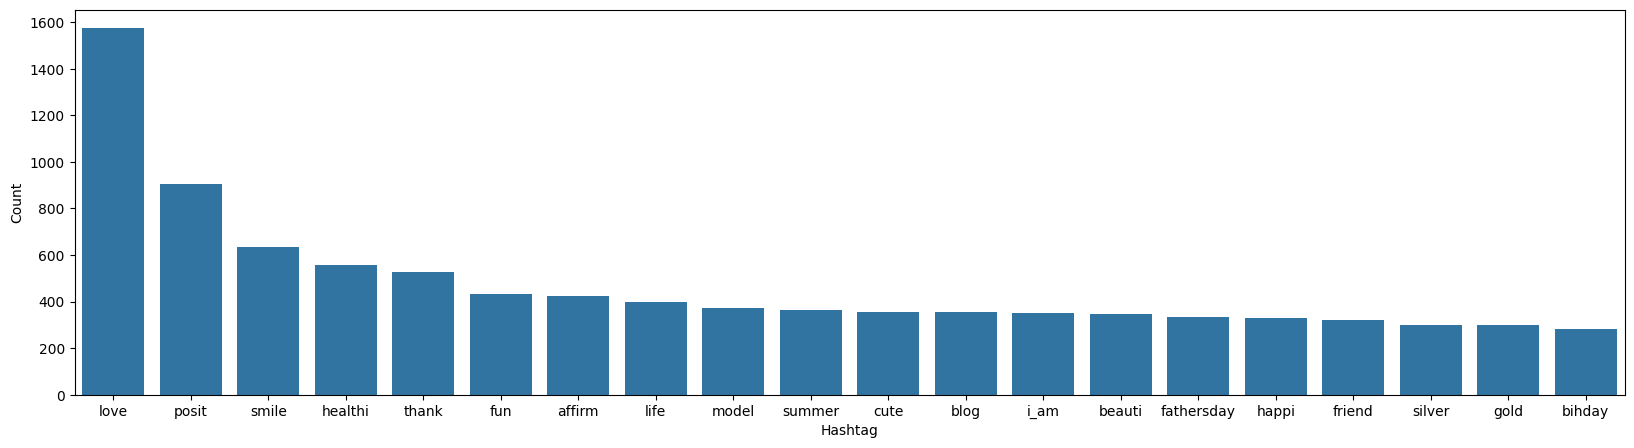

In [28]:
# selecting top 20 most frequent hashtags

d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
# plt.xticks(rotation=90)
plt.show()

All these hashtags are positive and it makes sense. I am expecting negative terms in the plot of the second list. Let’s check the most frequent hashtags appearing in the racist/sexist tweets.

**Racist/Sexist Tweets**

In [29]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame(
    {
    'Hashtag': list(a.keys()),
    'Count': list(a.values())
    }
)

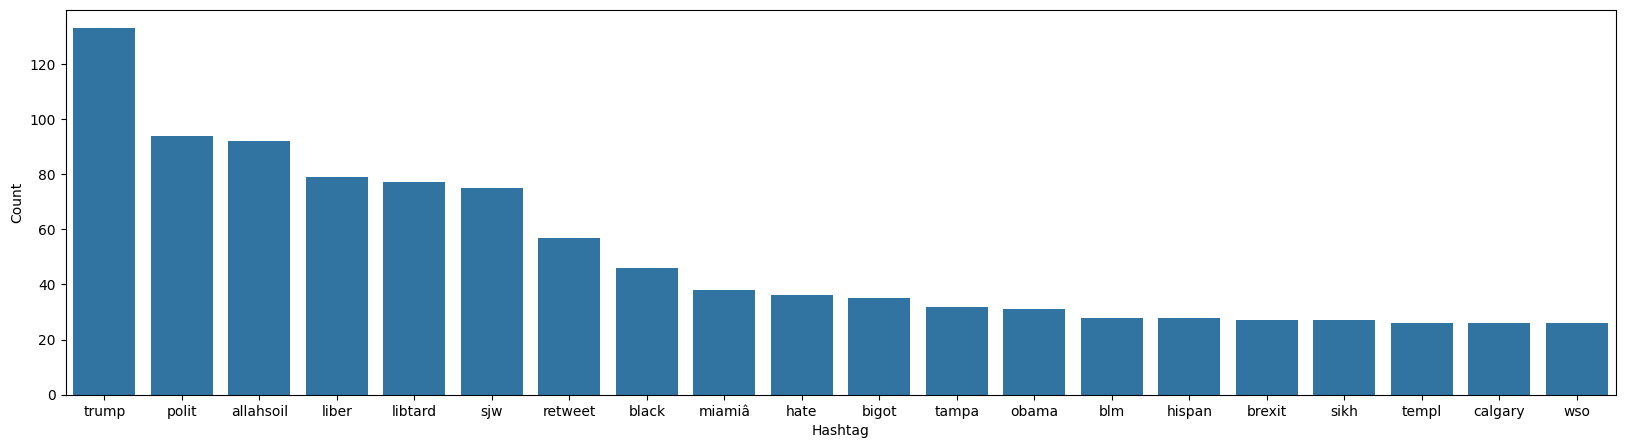

In [30]:
# selecting top 20 most frequent hashtags

d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
# plt.xticks(rotation=90)
plt.show()

As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.

#### Bag-of-Words Features

To analyse a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques – Bag of Words, TF-IDF, and Word Embeddings. Read on to understand these techniques in detail.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

Let’s start with the **Bag-of-Words** Features.

Consider a Corpus C of D documents {d1,d2…..dD} and N unique tokens extracted out of the corpus C. The N tokens (words) will form a dictionary and the size of the bag-of-words matrix M will be given by D X N. Each row in the matrix M contains the frequency of tokens in document D(i).

Let us understand this using a simple example.

D1: He is a lazy boy. She is also lazy.

D2: Smith is a lazy person.

The dictionary created would be a list of unique tokens in the corpus =[‘He’,’She’,’lazy’,’boy’,’Smith’,’person’]

Here, D=2, N=6

The matrix M of size 2 X 6 will be represented as –
![imgur](https://i.imgur.com/mKcTPdZ.png)

Now the columns in the above matrix can be used as features to build a classification model.

In [32]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape

(49159, 1000)

#### TF-IDF Features

This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account not just the occurrence of a word in a single document (or tweet) but in the entire corpus.

TF-IDF works by penalising the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

Let’s have a look at the important terms related to TF-IDF:

* TF = (Number of times term t appears in a document)/(Number of terms in the document)

* IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.

* TF-IDF = TF*IDF

In [33]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

(49159, 1000)

#### Word2Vec Features

Word embeddings are the modern way of representing words as vectors. The objective of word embeddings is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus. They are able to achieve tasks like **King -man +woman = Queen**, which is mind-blowing.

![imgur](https://i.imgur.com/gZiNamE.png)

The advantages of using word embeddings over BOW or TF-IDF are:

1. Dimensionality reduction - significant reduction in the no. of features required to build a model.

1. It capture meanings of the words, semantic relationships and the different types of contexts they are used in.

**1. Word2Vec Embeddings**

Word2Vec is not a single algorithm but a combination of two techniques – **CBOW (Continuous bag of words)** and **Skip-gram** model. Both of these are shallow neural networks which map word(s) to the target variable which is also a word(s). Both of these techniques learn weights which act as word vector representations.

CBOW tends to predict the probability of a word given a context. A context may be a single adjacent word or a group of surrounding words. The Skip-gram model works in the reverse manner, it tries to predict the context for a given word.

Below is a diagrammatic representation of a 1-word context window Word2Vec model.

![imgur](https://i.imgur.com/f77V0dH.png)

There are three laters: - an input layer, - a hidden layer, and - an output layer.

The input layer and the output, both are one- hot encoded of size [1 X V], where V is the size of the vocabulary (no. of unique words in the corpus). The output layer is a softmax layer which is used to sum the probabilities obtained in the output layer to 1. The weights learned by the model are then used as the word-vectors.

We will go ahead with the Skip-gram model as it has the following advantages:

* It can capture two semantics for a single word. i.e it will have two vector representations of ‘apple’. One for the company Apple and the other for the fruit.

* Skip-gram with negative sub-sampling outperforms CBOW generally.

We will train a Word2Vec model on our data to obtain vector representations for all the unique words present in our corpus. There is one more option of using **pre-trained word vectors** instead of training our own model. Some of the freely available pre-trained vectors are:

1. [Google News Word Vectors](https://code.google.com/archive/p/word2vec/)

1. [Freebase names](https://code.google.com/archive/p/word2vec/)

1. [DBPedia vectors (wiki2vec)](https://github.com/idio/wiki2vec#prebuilt-models)

However, for now, we will train our own word vectors since size of the pre-trained word vectors is generally huge.

Let’s train a Word2Vec model on our corpus.

In [34]:
%%time

tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
)

model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

CPU times: user 1min 36s, sys: 519 ms, total: 1min 37s
Wall time: 58.2 s


(6705625, 8184140)

Let’s play a bit with our Word2Vec model and see how does it perform. We will specify a word and the model will pull out the most similar words from the corpus.

In [35]:
model_w2v.wv.most_similar(positive="dinner")

[('spaghetti', 0.6277509331703186),
 ('#biall2016', 0.5985126495361328),
 ('lukey', 0.5873355269432068),
 ('yummi', 0.5750904679298401),
 ('shopping!', 0.5749558210372925),
 ('bay.', 0.5696397423744202),
 ('gown', 0.5692678093910217),
 ('sister!!', 0.5679052472114563),
 ('enrout', 0.5621491074562073),
 ('sushi', 0.561405599117279)]

In [36]:
model_w2v.wv.most_similar(positive="trump")

[('donald', 0.5595822930335999),
 ('suppoer.', 0.5541173815727234),
 ('fraud.', 0.5487221479415894),
 ('phony.', 0.5477214455604553),
 ('presidential.', 0.5468576550483704),
 ('#delegaterevolt', 0.5426649451255798),
 ('rally.', 0.5415993332862854),
 ('sexist.', 0.5403881669044495),
 ('businessman:', 0.5399490594863892),
 ('politician:', 0.539096474647522)]

From the above two examples, we can see that our word2vec model does a good job of finding the most similar words for a given word. But how is it able to do so? That’s because it has learned vectors for every unique word in our data and it uses cosine similarity to find out the most similar vectors (words).

Let’s check the vector representation of any word from our corpus.

In [37]:
model_w2v.wv['food']

array([-2.62586415e-01, -4.71753031e-01, -3.66615236e-01, -1.68705940e-01,
       -6.68526590e-02,  3.74451101e-01,  2.23312646e-01, -8.25173557e-01,
        1.07996023e+00,  3.38615954e-01, -3.21123190e-02,  2.78476238e-01,
       -2.25958750e-01, -5.08271277e-01,  2.15471134e-01,  5.25007308e-01,
        2.76951253e-01,  1.37490284e+00, -1.77997231e-01, -5.28539896e-01,
       -9.13147867e-01,  2.82188118e-01,  3.30745280e-02, -3.37987542e-01,
        1.23462282e-01,  5.87207913e-01,  3.84497404e-01, -5.40396869e-01,
       -1.41980678e-01, -2.49385223e-01, -1.66942477e-01,  5.70616834e-02,
        1.20878210e-02,  1.65616423e-01, -2.45369285e-01, -1.81023210e-01,
        2.23395452e-01,  1.53878018e-01,  8.10101271e-01,  7.25298673e-02,
       -9.25038517e-01, -8.26543272e-02,  1.81565046e-01, -9.26921889e-02,
       -2.16470703e-01,  6.63247406e-02,  5.28030276e-01, -5.23565590e-01,
        4.30675372e-02, -5.03186882e-01,  8.91078949e-01,  1.30514696e-01,
       -5.58924153e-02,  

In [38]:
len(model_w2v.wv['food']) #The length of the vector is 200

200

#### Preparing Vectors for Tweets

Since our data contains tweets and not just words, we’ll have to figure out a way to use the word vectors from word2vec model to create vector representation for an entire tweet. There is a simple solution to this problem, we can simply take mean of all the word vectors present in the tweet. The length of the resultant vector will be the same, i.e. 200. We will repeat the same process for all the tweets in our data and obtain their vectors. Now we have 200 word2vec features for our data.

We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [39]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

Preparing word2vec feature set…

In [40]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(49159, 200)

Now we have 200 new features, whereas in Bag of Words and TF-IDF we had 1000 features.

We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, and word2vec vectors. We will use the following algorithms to build models:

1. Logistic Regression
1. Support Vector Machine
1. RandomForest
1. XGBoost

**Evaluation Metric**

**F1 score** is being used as the evaluation metric. It is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is suitable for uneven class distribution problems.

The important components of F1 score are:

1. True Positives (TP) - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.
1. True Negatives (TN) - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.
1. False Positives (FP) – When actual class is no and predicted class is yes.
1. False Negatives (FN) – When actual class is yes but predicted class in no.

**Precision** = TP/TP+FP

**Recall** = TP/TP+FN

**F1 Score** = 2(Recall * Precision) / (Recall + Precision)

#### Logistic Regression

Logistic Regression is a classification algorithm. It is used to predict a binary outcome (1 / 0, Yes / No, True / False) given a set of independent variables. You can also think of logistic regression as a special case of linear regression when the outcome variable is categorical, where we are using log of odds as the dependent variable. In simple words, it predicts the probability of occurrence of an event by fitting data to a logit function.

The following equation is used in Logistic Regression:

![imgur](https://i.imgur.com/RpFof26.png)

A typical logistic model plot is shown below. You can see probability never goes below 0 and above 1.

![imgur](https://i.imgur.com/vX2dlga.png)

Read this [article](https://www.analyticsvidhya.com/blog/2015/11/beginners-guide-on-logistic-regression-in-r/) to know more about Logistic Regression.



In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

**Bag-of-Words Features**

We will first try to fit the logistic regression model on the Bag-of-Words (BoW) features.

In [42]:
# Extracting train and test BoW features
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression(solver='lbfgs')

# training the model
lreg.fit(xtrain_bow, ytrain)
prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(int)
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

0.545751633986928

**TF-IDF Features**

We’ll follow the same steps as above, but now for the TF-IDF feature set.

In [43]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(int)

f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

0.5407279029462738

**Word2Vec Features**

In [44]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

lreg.fit(xtrain_w2v, ytrain)

prediction = lreg.predict_proba(xvalid_w2v)

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(int)

f1_score(yvalid, prediction_int)

0.6048925129725723

#### Support Vector Machine (SVM)

Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. However, it is mostly used in classification problems. In this algorithm, we plot each data item as a point in n-dimensional space (where n is the number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes as shown in the plot below:

![imgur](https://i.imgur.com/dG1jOCx.png)

Refer this [article](https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/) to learn more about SVM. Now we will implement SVM on our data using the scikit-learn library.

In [45]:
from sklearn import svm

**Bag-of-Words Features**

In [46]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)
prediction = svc.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(int)
f1_score(yvalid, prediction_int)

0.5243790248390064

Here validation score is slightly lesser than the Logistic Regression score for bag-of-words features.

**TF-IDF Features**

In [47]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)
prediction = svc.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(int)
f1_score(yvalid, prediction_int)

0.51952770208901

**Word2Vec Features**

In [48]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain)
prediction = svc.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(int)
f1_score(yvalid, prediction_int)

0.6095836606441477

#### RandomForest

Random Forest is a versatile machine learning algorithm capable of performing both regression and classification tasks. It is a kind of ensemble learning method, where a few weak models combine to form a powerful model. In Random Forest, we grow multiple trees as opposed to a decision single tree. To classify a new object based on attributes, each tree gives a classification and we say the tree “votes” for that class. The forest chooses the classification having the most votes (over all the trees in the forest).

It works in the following manner. Each tree is planted & grown as follows:

1. Assume number of cases in the training set is N. Then, sample of these N cases is taken at random but with replacement. This sample will be the training set for growing the tree.

1. If there are M input variables, a number m (m<M) is specified such that at each node, m variables are selected at random out of the M. The best split on these m variables is used to split the node. The value of m is held constant while we grow the forest.

1. Each tree is grown to the largest extent possible and there is no pruning.

1. Predict new data by aggregating the predictions of the ntree trees (i.e., majority votes for classification, average for regression).

![imgur](https://i.imgur.com/nOBROEn.png)

In [49]:
from sklearn.ensemble import RandomForestClassifier

**Bag-of-Words Features**

First we will train our RandomForest model on the Bag-of-Words features and check its performance on validation set.

In [50]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain)
prediction = rf.predict(xvalid_bow)
f1_score(yvalid, prediction) # validation score

0.5205905205905206

**TF-IDF Features**

In [51]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain)
prediction = rf.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

**Word2Vec Features**

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain)
prediction = rf.predict(xvalid_w2v)
f1_score(yvalid, prediction)

0.48642779587404994

#### XGBoost

Extreme Gradient Boosting (xgboost) is an advanced implementation of gradient boosting algorithm. It has both linear model solver and tree learning algorithms. Its ability to do parallel computation on a single machine makes it extremely fast. It also has additional features for doing cross validation and finding important variables. There are many parameters which need to be controlled to optimize the model.

Some key benefits of XGBoost are:

1. **Regularization** - helps in reducing overfitting

1. **Parallel Processing** - XGBoost implements parallel processing and is blazingly faster as compared to GBM.

1. **Handling Missing Values** - It has an in-built routine to handle missing values.

1. **Built-in Cross-Validation** - allows user to run a cross-validation at each iteration of the boosting process

Check out this wonderful guide on XGBoost parameter tuning.

In [ ]:
from xgboost import XGBClassifier

**Bag-of-Words Features**

In [ ]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain)
prediction = xgb_model.predict(xvalid_bow)
f1_score(yvalid, prediction)

0.5411764705882353

**TF-IDF Features**

In [ ]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain)
prediction = xgb.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

0.5318761384335154

**Word2Vec Features**

In [ ]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain)
prediction = xgb.predict(xvalid_w2v)
f1_score(yvalid, prediction)

0.617781851512374

XGBoost model on word2vec features has outperformed all the previuos models

### Q1: Which combination of feature and Classification models achieves the best performance?

XGBoost model with Word2 Vector Features achieves the best performance, with F1 score of 0.62

### Q2: Try pretrained word vectors (like GloVe) and compare the classification performance.

In [ ]:
# pretrained word vectors, compare the classification results.
import numpy as np
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

# You need to downloaded the GloVe pre-trained vectors and unzipped them first
# Due to the size of the pre-trained vectors, please complete this part after class
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

# Load the converted GloVe vectors
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

/tmp/ipykernel_39381/938516495.py:10: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [ ]:
# use the glove_model to get the word vector for each word in the tokenized_tweet, try to reshape the vector to 200 dimensions
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += glove_model[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue

wordvec_arrays_1 = np.zeros((len(tokenized_tweet), 200))

NameError: name 'tokenized_tweet' is not defined

In [ ]:
for i in range(len(tokenized_tweet)):
    wordvec_arrays_1[i,:] = word_vector(tokenized_tweet[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

In [ ]:
# use XGBoost to predict the sentiment, but this time using the GloVe word vectors
xtrain_glove = wordvec_df.iloc[ytrain.index,:]
xvalid_glove = wordvec_df.iloc[yvalid.index,:]

xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_glove, ytrain)
prediction = xgb.predict(xvalid_glove)
f1_score(yvalid, prediction)

0.474059003051882